In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
from numpy.random import choice
from scipy.optimize import curve_fit

In [4]:
import matplotlib.pyplot as plt
from plotting import initialize_plot_settings
initialize_plot_settings()

In [5]:
from disloc import deform_dislocation
from utils import apply_water_mask, load_and_mask_results, rotate

In [6]:
ORIGIN_X = 321660
ORIGIN_Y = 4164942

In [38]:
filename = f'results/sfm/strike_slip/HSLSurvey101419_utm_s310.00_d90.00_dep100.00_ss1.00_ds0.00_ICP_w50.00_str25.00.pkl'
x, y, ux, uy, uz, residual, mask = load_and_mask_results(filename, iterations=2)
xx, yy = np.meshgrid(x, y)

## Convenience functions

In [8]:
def rmse(ypred, yobs):
    return np.sqrt(np.nanmean((ypred - yobs) ** 2))

In [14]:
def center_profiles(uobs, utrue, dx=25):
    n = len(uobs)
    idx = np.where(uobs == np.sign(uobs) * np.min(np.abs(uobs)))[0][0]
    xp = np.arange(2*(n - idx), dtype=float)
    xp -= np.mean(xp)
    x = dx * xp - dx / 2
    if 2*idx - n < 0:
        return x[np.abs(2*idx - n)+1:], uobs[np.abs(2*idx - n):], utrue[np.abs(2*idx - n):]        
    return x, uobs[(2*idx - n):], utrue[(2*idx - n):]

In [15]:
def model_1d(x, depth, s):
    delta = 89.999
    deltarad = np.deg2rad(delta)
    zeta = (x / depth) - (1 / np.tan(deltarad))
    u1 = (s/np.pi)*(np.cos(deltarad)*np.arctan(zeta) + (np.sin(deltarad) - zeta*np.cos(deltarad))/(1+np.power(zeta,2)))
    u2 = (-s/np.pi)*(np.sin(deltarad)*np.arctan(zeta) + (np.cos(deltarad) + zeta*np.sin(deltarad))/(1+np.power(zeta,2)))
    return u2

In [9]:
def model_2d(depth, slip_ds, slip_ss, strike=310, dip=89.999, x=x, y=y, origin_x=ORIGIN_X, origin_y=ORIGIN_Y):
    if x.ndim < 2:
        x, y = np.meshgrid(x, y)
    x0 = np.mean(x) if origin_x is None else origin_x
    y0 = np.mean(y) if origin_y is None else origin_y

    xt = x - x0
    yt = y - y0

    deltarad = np.deg2rad(dip)
    thetarad = np.deg2rad(strike)
    X1p = xt * np.cos(np.pi - thetarad) + yt * np.sin(np.pi - thetarad)
    Zeta = (X1p / depth) - (1 / np.tan(deltarad))
    u1 = (slip_ds / np.pi) * (
        np.cos(deltarad) * np.arctan(Zeta)
        + (np.sin(deltarad) - Zeta * np.cos(deltarad)) / (1 + np.power(Zeta, 2))
    )
    u3 = (-slip_ds / np.pi) * (
        np.sin(deltarad) * np.arctan(Zeta)
        + (np.cos(deltarad) + Zeta * np.sin(deltarad)) / (1 + np.power(Zeta, 2))
    )
    u2 = (slip_ss / np.pi) * (
        np.arctan2(
            Zeta * np.power(np.sin(deltarad), 2),
            (1 - Zeta * np.sin(deltarad) * np.cos(deltarad)),
        )
        + (deltarad - np.sign(deltarad) * np.pi / 2.0)
    )

    u1p = u1 * np.cos(thetarad - np.pi) + u2 * np.sin(thetarad - np.pi)
    u2p = -u1 * np.sin(thetarad - np.pi) + u2 * np.cos(thetarad - np.pi)
    
    up, un = rotate(u1p, u2p, theta=50)
    
    return up, u3

In [17]:
def model_2d_profile(depth, slip_ds, slip_ss, strike=310, dip=89.999, x=x, y=y, origin_x=ORIGIN_X, origin_y=ORIGIN_Y):
    if x.ndim < 2:
        x, y = np.meshgrid(x, y)
    x0 = np.mean(x) if origin_x is None else origin_x
    y0 = np.mean(y) if origin_y is None else origin_y

    xt = x - x0
    yt = y - y0

    deltarad = np.deg2rad(dip)
    thetarad = np.deg2rad(strike)
    X1p = xt * np.cos(np.pi - thetarad) + yt * np.sin(np.pi - thetarad)
    Zeta = (X1p / depth) - (1 / np.tan(deltarad))
    u1 = (slip_ds / np.pi) * (
        np.cos(deltarad) * np.arctan(Zeta)
        + (np.sin(deltarad) - Zeta * np.cos(deltarad)) / (1 + np.power(Zeta, 2))
    )
    u3 = (-slip_ds / np.pi) * (
        np.sin(deltarad) * np.arctan(Zeta)
        + (np.cos(deltarad) + Zeta * np.sin(deltarad)) / (1 + np.power(Zeta, 2))
    )
    u2 = (slip_ss / np.pi) * (
        np.arctan2(
            Zeta * np.power(np.sin(deltarad), 2),
            (1 - Zeta * np.sin(deltarad) * np.cos(deltarad)),
        )
        + (deltarad - np.sign(deltarad) * np.pi / 2.0)
    )

    u1p = u1 * np.cos(thetarad - np.pi) + u2 * np.sin(thetarad - np.pi)
    u2p = -u1 * np.sin(thetarad - np.pi) + u2 * np.cos(thetarad - np.pi)
    
    up, un = rotate(u1p, u2p, theta=50)
    
    ij = []
    j = 0
    for i in np.arange(0, up.shape[0], dtype=int):
        ij.append([i, j])
        j += 1
        if j >= up.shape[1]:
            break
    ij = np.array(ij)
    
    return up[ij[:, 0], ij[:, 1]], u3[ij[:, 0], ij[:, 1]]

In [18]:
def extract_disp_profile(filename, kind='z'):
    x, y, ux, uy, uz, residual, mask = load_and_mask_results(filename, iterations=2)
    
    if kind =='z':
        u = uz
    elif kind == 's':
        u, _ = rotate(ux, uy, theta=50)
        
    ij = []
    j = 0
    for i in np.arange(0, u.shape[0], dtype=int):
        ij.append([i, j])
        j += 1
        if j >= u.shape[1]:
            break
    ij = np.array(ij)
    
    return u[ij[:, 0], ij[:, 1]]

In [10]:
depth = 100
dip_slip = 1
dxs = [5, 12.5, 25, 50, 100]

In [11]:
us = np.load('profiles/lidar_ds_applied.npy', allow_pickle=True)

In [12]:
uicps = np.load('profiles/lidar_ds_observed.npy', allow_pickle=True)

In [17]:
dx = dxs[0]
uobs = uicps[0]
utrue = us[0]

xp, uobsc, utruec = center_profiles(uobs, utrue, dx=dx)

phat, pcov = curve_fit(model_1d, xp, uobsc)
uhat = model_1d(xp, *phat)
print(phat)

plt.plot(xp, uobsc, 'wo', mec='k', label='ICP')
plt.plot(xp, utruec, 'k-', label='True')
plt.plot(xp, uhat, 'k--', label='Best fit')
plt.legend()

In [ ]:
fig, axes = plt.subplots(len(dxs), 1, figsize=(6, 3 * len(dxs)), sharex=True)
letters = ['A', 'B', 'C', 'D', 'E']
for ax, letter, dx, utrue, uobs in zip(axes, letters, dxs, us, uicps):
    x, uobsc, _ = center_profiles(uobs, utrue, dx=dx)
    phat, pcov = curve_fit(model_1d, x, uobsc)
    uhat = model_1d(xp, *phat)
    ax.plot(x, uobsc, 'wo', mec='k', label='Measured (ICP)')
    ax.plot(xp, utruec, 'k-', label='True')
    ax.plot(xp, uhat, 'k--', label='Best fit')
        
    ax.text(0.025, 0.9, letter, transform=ax.transAxes, fontsize=14)
    ax.text(0.75, 0.1, "$dx$ = " + f"{dx:.1f} m\n" + "$\hat{d}$ = " + f"{phat[0]:.2f} m \n" + "$\hat{s_z}$ = " + f"{phat[1]:.2f} m", transform=ax.transAxes, fontsize=14)
        
axes[0].legend()        
axes[-1].set_xticks([-400, 0, 400])
axes[-1].set_xticklabels(['0', '400', '800'])
axes[-1].set_xlabel('Distance [m]')
axes[2].set_ylabel('Displacement $u_z$ [m]')

plt.savefig('/media/rmsare/data/fig/hsl_icp/FigureSX_LidarResolutionDSModels.png', dpi=300, bbox_inches='tight')

## Misfit plots

## Dip slip

In [482]:
def plot_rmse_1d(uobs, utrue, dx=25):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    xp, uobsc, utruec = center_profiles(uobs, utrue, dx=dx)
    #xp = dx * np.arange(len(uobs))
    #uobsc = uobs

    depths = np.linspace(0, -500, num=100) + 0.01
    slips = np.linspace(0, 5, num=100) + 0.01
    rmses = np.full((len(depths), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, s in enumerate(slips):
            upred = model_1d(xp, depth, s)
            rmses[i, j] = rmse(upred, uobsc)        
    
    im = ax[0].imshow(np.log10(rmses), extent=extent, cmap='viridis_r')
    _ = ax[0].contour(np.log10(rmses), [-1, -0.75, -0.5, -0.25, 0], extent=extent, colors='w', origin='upper')
    #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])
    ax[0].set_aspect(0.005)
    ax[0].set_xlabel('Slip [m]')
    ax[0].set_ylabel('Depth [m]')
    
    idx = np.where(rmses == rmses.min())
    i = idx[0][0]
    j = idx[1][0]
    
    ax[1].plot(depths, rmses[:, j], 'k-')
    ax[1].set_xlim(-500, -10)
    ax[1].set_xticks([-300, -100])
    ax[1].set_ylim([0, 0.3])
    ax[1].set_yticks([0, 0.15, 0.3])
    ax[1].set_xlabel('Depth [m]')
    ax[1].set_ylabel('RMSE [m]')
    
    ax[2].plot(slips, rmses[i, :], 'k-')
    ax[2].set_xlim([0, 3])
    ax[2].set_xticks([0, 1, 2])
    ax[2].set_ylim([0, 1])
    ax[2].set_yticks([0, 0.5, 1])
    ax[2].set_xlabel('Slip [m]')

    plt.subplots_adjust(wspace=0.5)
    
    print(f'Min. RMSE: dx = {dx:.1f} m depth = {depths[i]:.1f} m, slip = {slips[j]:.1f} m, RMSE = {rmses[i, j]:.2f} m')

In [483]:
us = np.load('profiles/lidar_ds_applied.npy', allow_pickle=True)
uicps = np.load('profiles/lidar_ds_observed.npy', allow_pickle=True)

Min. RMSE: dx = 5.0 m depth = -75.7 m, slip = 1.0 m, RMSE = 0.05 m
Min. RMSE: dx = 12.5 m depth = -75.7 m, slip = 1.0 m, RMSE = 0.04 m
Min. RMSE: dx = 25.0 m depth = -70.7 m, slip = 1.0 m, RMSE = 0.05 m
Min. RMSE: dx = 50.0 m depth = -101.0 m, slip = 1.1 m, RMSE = 0.06 m
Min. RMSE: dx = 100.0 m depth = -212.1 m, slip = 1.4 m, RMSE = 0.11 m


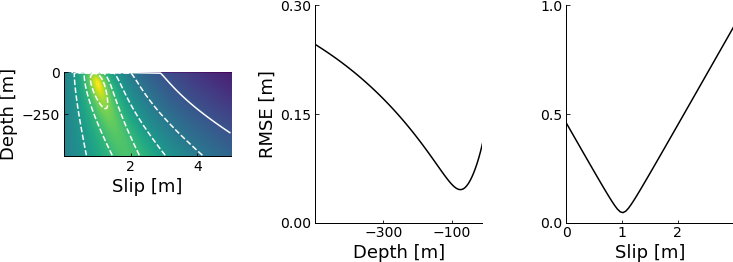

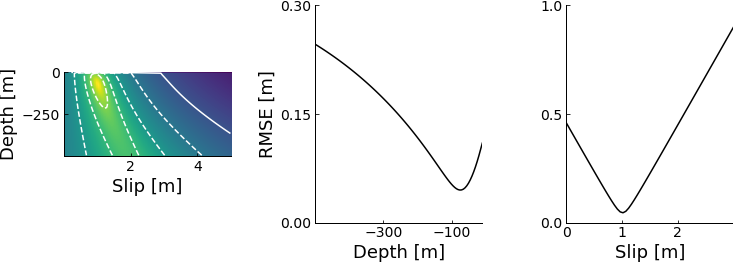

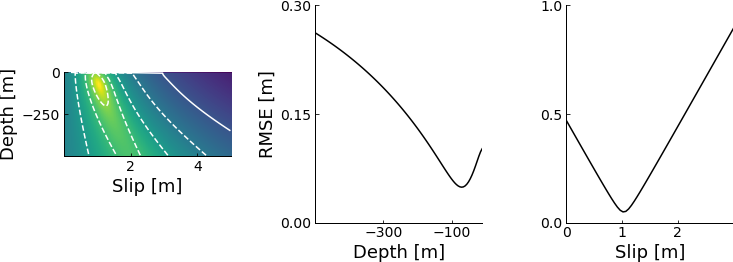

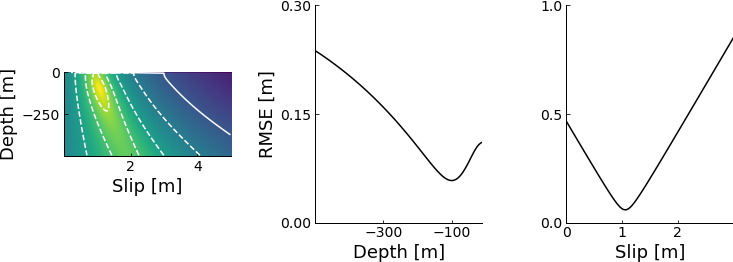

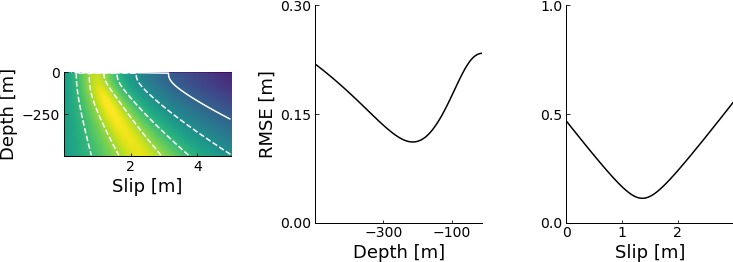

In [484]:
for uobs, utrue, dx in zip(uicps, us, dxs):
    plot_rmse_1d(uobs, utrue, dx=dx)

## RMSE - 2D disp. field

In [19]:
def plot_rmse_2d_dipslip(dx=50):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    filename = f'results/sfm/dip_slip/HSLSurvey101419_utm_s310.00_d90.00_dep100.00_ss0.00_ds1.00_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uobs, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    uobs = apply_water_maskater_mask(uobs, dx=dx)
    
    depths = np.linspace(0, 500, num=100) + 0.01
    slips = np.linspace(0, 5, num=100) + 0.01
    rmses = np.full((len(depths), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, s in enumerate(slips):
            _, upred = model_2d(depth, slip_ds=s, slip_ss=0, x=x, y=y)
            rmses[i, j] = rmse(upred, uobs)        
    
    im = ax[0].imshow(np.log10(rmses), extent=extent, cmap='viridis_r')
    _ = ax[0].contour(np.log10(rmses), [-1, -0.75, -0.5, -0.25, 0], extent=extent, colors='w', origin='upper')
    #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])
    ax[0].set_aspect(0.005)
    ax[0].set_xlabel('Slip [m]')
    ax[0].set_ylabel('Depth [m]')
    
    idx = np.where(rmses == rmses.min())
    i = idx[0][0]
    j = idx[1][0]
    
    ax[1].plot(depths, rmses[:, j], 'k-')
    ax[1].set_xlabel('Depth [m]')
    ax[1].set_ylabel('RMSE [m]')
    
    ax[2].plot(slips, rmses[i, :], 'k-')
    ax[2].set_xlabel('Slip [m]')

    plt.subplots_adjust(wspace=0.5)

    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, slip = {slips[j]:.1f} m, RMSE = {rmses[i, j]:.2f} m')

In [20]:
def plot_rmse_2d_strikeslip(dx=50):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    filename = f'results/sfm/strike_slip/HSLSurvey101419_utm_s310.00_d90.00_dep100.00_ss1.00_ds0.00_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uz, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    
    uobs, _ = rotate(ux, uy, theta=50)
    uobs = apply_water_maskater_mask(uobs, dx=dx)
    
    depths = np.linspace(0, 500, num=100) + 0.01
    slips = np.linspace(0, 5, num=100) + 0.01
    rmses = np.full((len(depths), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, s in enumerate(slips):
            upred, _ = model_2d(depth, slip_ds=0, slip_ss=s, x=x, y=y)
            rmses[i, j] = rmse(upred, uobs)        
    
    im = ax[0].imshow(np.log10(rmses), extent=extent, cmap='viridis_r')
    _ = ax[0].contour(np.log10(rmses), [-1, -0.75, -0.5, -0.25, 0], extent=extent, colors='w', origin='upper')
    #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])
    ax[0].set_aspect(0.005)
    ax[0].set_xlabel('Slip [m]')
    ax[0].set_ylabel('Depth [m]')
    
    idx = np.where(rmses == rmses.min())
    i = idx[0][0]
    j = idx[1][0]
    
    ax[1].plot(depths, rmses[:, j], 'k-')
    ax[1].set_xlabel('Depth [m]')
    ax[1].set_ylabel('RMSE [m]')
    
    ax[2].plot(slips, rmses[i, :], 'k-')
    ax[2].set_xlabel('Slip [m]')

    plt.subplots_adjust(wspace=0.5)

    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, slip = {slips[j]:.1f} m, RMSE = {rmses[i, j]:.2f} m')

In [ ]:
windows = [10, 25, 50, 100]
for w in windows:
    plot_rmse_2d_dipslip(dx=w)

In [ ]:
windows = [50]
for w in windows:
    plot_rmse_2d_strikeslip(dx=w)

## RMSE - 2D disp. field, both strike and dip slip

In [79]:
def plot_rmse_2param_dipslip_lidar(dx=50, num=100, max_depth=500, max_slip=5, levels=[0.25, 0.5, 1], ax=None, color='k', normalize=False):
    filename = f'results/lidar/dip_slip/HSLLidar_2017_s310.00_d90.00_dep100.00_ss0.00_ds1.00_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uobs, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    uobs = apply_water_mask(uobs, dx=dx)
    
    depths = np.linspace(0, max_depth, num=num) + 0.01
    slips = np.linspace(0, max_slip, num=num) + 0.01
    rmses = np.full((len(depths), len(slips), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, ds in enumerate(slips):
            for k, ss in enumerate(slips):
                _, upred = model_2d(depth, slip_ds=ds, slip_ss=ss, x=x, y=y)
                rmses[i, j, k] = rmse(upred, uobs)        
    
    idx = np.where(rmses == np.nanmin(rmses))
    i = idx[0][0]
    j = idx[1][0]
    k = idx[2][0]
    
    if dx == 50:
        im = ax[0].imshow(rmses[:, :, k], extent=extent, aspect='auto', cmap='gray')
        c = ax[0].contour(rmses[:, :, k], levels=levels, extent=extent, aspect='auto', colors='w', origin='upper')
        ax[0].plot(slips[j], depths[i], 'w*', ms=10)
        ax[0].clabel(c, fmt='%.1f m', fontsize=12)
        #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])

        ax[0].invert_yaxis()
        ax[0].set_xlim([0, max_slip])
    
    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, dip slip = {slips[j]:.1f} m, strike slip = {slips[k]:.1f} m, RMSE = {rmses[i, j, k]:.2f} m')
    
    if normalize:
        rmses /= 0.03
    
    ax[1].plot(depths, rmses[:, j, k], '-', c=color, label=f'{dx:.0f} m')
    
    ax[2].plot(slips, rmses[i, :, k], '-', c=color, label=f'{dx:.0f} m')    
    ax[2].plot(slips, rmses[i, j, :], '--', c=color)

    return depths, slips, rmses


In [80]:
def plot_rmse_2param_dipslip_lidar_filt(dx=50, num=100, max_depth=500, max_slip=5, levels=[0.25, 0.5, 1], ax=None, color='k', normalize=False):
    filename = f'results/lidar/dip_slip/HSLLidar_2017_filt_s310.00_d90.00_dep100.00_ss0.00_ds1.00_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uobs, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    uobs = apply_water_mask(uobs, dx=dx)
    
    depths = np.linspace(0, max_depth, num=num) + 0.01
    slips = np.linspace(0, max_slip, num=num) + 0.01
    rmses = np.full((len(depths), len(slips), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, ds in enumerate(slips):
            for k, ss in enumerate(slips):
                _, upred = model_2d(depth, slip_ds=ds, slip_ss=ss, x=x, y=y)
                rmses[i, j, k] = rmse(upred, uobs)        
    
    idx = np.where(rmses == np.nanmin(rmses))
    i = idx[0][0]
    j = idx[1][0]
    k = idx[2][0]
    
    if dx == 50:
        im = ax[0].imshow(rmses[:, :, k], extent=extent, aspect='auto', cmap='gray')
        c = ax[0].contour(rmses[:, :, k], levels=levels, extent=extent, aspect='auto', colors='w', origin='upper')
        ax[0].plot(slips[j], depths[i], 'w*', ms=10)
        ax[0].clabel(c, fmt='%.1f m', fontsize=12)
        #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])

        ax[0].invert_yaxis()
        ax[0].set_xlim([0, max_slip])
    
    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, dip slip = {slips[j]:.1f} m, strike slip = {slips[k]:.1f} m, RMSE = {rmses[i, j, k]:.2f} m')
    
    if normalize:
        rmses /= 0.03
    
    ax[1].plot(depths, rmses[:, j, k], '-', c=color, label=f'{dx:.0f} m')
    
    ax[2].plot(slips, rmses[i, :, k], '-', c=color, label=f'{dx:.0f} m')    
    ax[2].plot(slips, rmses[i, j, :], '--', c=color)

    return depths, slips, rmses


In [81]:
def plot_rmse_2param_strikeslip_lidar(dx=50, num=100, max_depth=500, max_slip=5, levels=[0.25, 0.5, 1], ax=None, color='k', normalize=False):
    filename = f'results/lidar/strike_slip/HSLLidar_2017_s310.00_d90.00_dep100.00_ss1.00_ds0.00_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uobs, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    uobs, _ = rotate(ux, uy, theta=50)
    uobs = apply_water_mask(uobs, dx=dx)

    depths = np.linspace(0, max_depth, num=num) + 0.01
    slips = np.linspace(0, max_slip, num=num) + 0.01
    rmses = np.full((len(depths), len(slips), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, ds in enumerate(slips):
            for k, ss in enumerate(slips):
                upred, _ = model_2d(depth, slip_ds=ds, slip_ss=ss, x=x, y=y)
                rmses[i, j, k] = rmse(upred, uobs)        
    
    idx = np.where(rmses == np.nanmin(rmses))
    i = idx[0][0]
    j = idx[1][0]
    k = idx[2][0]
    
    if dx == 50:
        im = ax[0].imshow(rmses[:, j, :], extent=extent, aspect='auto', cmap='gray')
        c = ax[0].contour(rmses[:, j, :], levels=levels, extent=extent, aspect='auto', colors='w', origin='upper')
        ax[0].plot(slips[k], depths[i], 'w*', ms=10)
        ax[0].clabel(c, fmt='%.1f m', fontsize=12)
        #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])

        ax[0].invert_yaxis()
        ax[0].set_xlim([0, max_slip])
    
    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, dip slip = {slips[j]:.1f} m, strike slip = {slips[k]:.1f} m, RMSE = {rmses[i, j, k]:.2f} m')
    
    if normalize:
        rmses /= 0.09
    
    ax[1].plot(depths, rmses[:, j, k], '-', c=color, label=f'{dx:.0f} m')
    
    ax[2].plot(slips, rmses[i, :, k], '-', c=color, label=f'{dx:.0f} m')    
    ax[2].plot(slips, rmses[i, j, :], '--', c=color)

    return depths, slips, rmses

In [82]:
def plot_rmse_2param_strikeslip_lidar_filt(dx=50, num=100, max_depth=500, max_slip=5, levels=[0.25, 0.5, 1], ax=None, color='k', normalize=False):
    filename = f'results/lidar/strike_slip/HSLLidar_2017_filt_s310.00_d90.00_dep100.00_ss1.00_ds0.00_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uz, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    uobs, _ = rotate(ux, uy, theta=50)
    uobs = apply_water_mask(uobs, dx=dx)
    
    depths = np.linspace(0, max_depth, num=num) + 0.01
    slips = np.linspace(0, max_slip, num=num) + 0.01
    rmses = np.full((len(depths), len(slips), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, ds in enumerate(slips):
            for k, ss in enumerate(slips):
                upred, _ = model_2d(depth, slip_ds=ds, slip_ss=ss, x=x, y=y)
                rmses[i, j, k] = rmse(upred, uobs)        
    
    idx = np.where(rmses == np.nanmin(rmses))
    i = idx[0][0]
    j = idx[1][0]
    k = idx[2][0]
    
    if dx == 50:
        im = ax[0].imshow(rmses[:, j, :], extent=extent, aspect='auto', cmap='gray')
        c = ax[0].contour(rmses[:, j, :], levels=levels, extent=extent, aspect='auto', colors='w', origin='upper')
        ax[0].plot(slips[k], depths[i], 'w*', ms=10)
        ax[0].clabel(c, fmt='%.1f m', fontsize=12)
        #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])

        ax[0].invert_yaxis()
        ax[0].set_xlim([0, max_slip])
    
    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, dip slip = {slips[j]:.1f} m, strike slip = {slips[k]:.1f} m, RMSE = {rmses[i, j, k]:.2f} m')
    
    if normalize:
        rmses /= 0.09
    
    ax[1].plot(depths, rmses[:, j, k], '-', c=color, label=f'{dx:.0f} m')
    
    ax[2].plot(slips, rmses[i, :, k], '-', c=color, label=f'{dx:.0f} m')    
    ax[2].plot(slips, rmses[i, j, :], '--', c=color)

    return depths, slips, rmses


In [83]:
def plot_rmse_2param_dipslip_sameday(dx=50, num=100, max_depth=500, max_slip=5, ax=None, color='k', normalize=False):
    filename = f'results/sfm/dip_slip/HSLSurvey101319_utm_s310.00_d90.00_dep100.00_ss0.00_ds1.00_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uobs, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    uobs = apply_water_mask(uobs, dx=dx)
    
    depths = np.linspace(0, max_depth, num=num) + 0.01
    slips = np.linspace(0, max_slip, num=num) + 0.01
    rmses = np.full((len(depths), len(slips), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, ds in enumerate(slips):
            for k, ss in enumerate(slips):
                _, upred = model_2d(depth, slip_ds=ds, slip_ss=ss, x=x, y=y)
                rmses[i, j, k] = rmse(upred, uobs)        
    
    idx = np.where(rmses == np.nanmin(rmses))
    i = idx[0][0]
    j = idx[1][0]
    k = idx[2][0]
    
    if dx == 50:
        im = ax[0].imshow(rmses[:, :, k], extent=extent, aspect='auto', cmap='gray')
        c = ax[0].contour(rmses[:, :, k], levels=[0.2, 0.6, 1], extent=extent, aspect='auto', colors='w', origin='upper')
        ax[0].plot(slips[j], depths[i], 'w*', ms=10)
        ax[0].clabel(c, fmt='%.1f m', fontsize=12)
        #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])

        ax[0].invert_yaxis()
        ax[0].set_xlim([0, max_slip])
    
    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, dip slip = {slips[j]:.1f} m, strike slip = {slips[k]:.1f} m, RMSE = {rmses[i, j, k]:.2f} m')
    
    if normalize:
        rmses /= 0.07
        #rmses /= np.nanmin(rmses)
    
    ax[1].plot(depths, rmses[:, j, k], '-', c=color, label=f'{dx:.0f} m')
    
    ax[2].plot(slips, rmses[i, :, k], '-', c=color, label=f'{dx:.0f} m')    
    ax[2].plot(slips, rmses[i, j, :], '--', c=color)

    return depths, slips, rmses


In [84]:
def plot_rmse_2param_dipslip(dx=50, num=100, max_depth=500, max_slip=5, ax=None, color='k', normalize=False):
    filename = f'results/sfm/dip_slip/HSLSurvey101419_utm_s310.00_d90.00_dep100.00_ss0.00_ds1.00_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uobs, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    uobs = apply_water_mask(uobs, dx=dx)
    
    depths = np.linspace(0, max_depth, num=num) + 0.01
    slips = np.linspace(0, max_slip, num=num) + 0.01
    rmses = np.full((len(depths), len(slips), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, ds in enumerate(slips):
            for k, ss in enumerate(slips):
                _, upred = model_2d(depth, slip_ds=ds, slip_ss=ss, x=x, y=y)
                rmses[i, j, k] = rmse(upred, uobs)        
    
    idx = np.where(rmses == np.nanmin(rmses))
    i = idx[0][0]
    j = idx[1][0]
    k = idx[2][0]
    
    if dx == 50:
        im = ax[0].imshow(rmses[:, :, k], extent=extent, aspect='auto', cmap='gray')
        c = ax[0].contour(rmses[:, :, k], levels=[0.6, 1, 1.5], extent=extent, aspect='auto', colors='w', origin='upper')
        ax[0].plot(slips[j], depths[i], 'w*', ms=10)
        ax[0].clabel(c, fmt='%.1f m', fontsize=12)
        #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])

        ax[0].invert_yaxis()
        ax[0].set_xlim([0, max_slip])
    
    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, dip slip = {slips[j]:.1f} m, strike slip = {slips[k]:.1f} m, RMSE = {rmses[i, j, k]:.2f} m')
    
    if normalize:
        rmses /= 0.07
        #rmses /= np.nanmin(rmses)
    
    ax[1].plot(depths, rmses[:, j, k], '-', c=color, label=f'{dx:.0f} m')
    
    ax[2].plot(slips, rmses[i, :, k], '-', c=color, label=f'{dx:.0f} m')    
    ax[2].plot(slips, rmses[i, j, :], '--', c=color)

    return depths, slips, rmses


In [85]:
def plot_rmse_2param_dipslip_filt(dx=50, num=100, max_depth=500, max_slip=5, ax=None, color='k', normalize=False):
    filename = f'results/sfm/dip_slip/HSLSurvey101419_utm_thin5_mccrgbground_s310.00_d90.00_dep100.00_ss0.00_ds1.00_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uobs, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    uobs = apply_water_mask(uobs, dx=dx)
    
    depths = np.linspace(0, max_depth, num=num) + 0.01
    slips = np.linspace(0, max_slip, num=num) + 0.01
    rmses = np.full((len(depths), len(slips), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, ds in enumerate(slips):
            for k, ss in enumerate(slips):
                _, upred = model_2d(depth, slip_ds=ds, slip_ss=ss, x=x, y=y)
                rmses[i, j, k] = rmse(upred, uobs)        
    
    idx = np.where(rmses == np.nanmin(rmses))
    i = idx[0][0]
    j = idx[1][0]
    k = idx[2][0]
    
    if dx == 50:
        im = ax[0].imshow(rmses[:, :, k], extent=extent, aspect='auto', cmap='gray')
        c = ax[0].contour(rmses[:, :, k], levels=[0.3, 0.6, 1], extent=extent, aspect='auto', colors='w', origin='upper')
        ax[0].plot(slips[j], depths[i], 'w*', ms=10)
        ax[0].clabel(c, fmt='%.1f m', fontsize=12)
        #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])

        ax[0].invert_yaxis()
        ax[0].set_xlim([0, max_slip])
    
    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, dip slip = {slips[j]:.1f} m, strike slip = {slips[k]:.1f} m, RMSE = {rmses[i, j, k]:.2f} m')
    
    if normalize:
        rmses /= 0.07
        #rmses /= np.nanmin(rmses)
    
    ax[1].plot(depths, rmses[:, j, k], '-', c=color, label=f'{dx:.0f} m')
    
    ax[2].plot(slips, rmses[i, :, k], '-', c=color, label=f'{dx:.0f} m')    
    ax[2].plot(slips, rmses[i, j, :], '--', c=color)

    return depths, slips, rmses


In [86]:
def plot_rmse_2param_strikeslip_sameday(dx=50, num=100, max_depth=500, max_slip=5, ax=None, color='k', normalize=False):
    
    filename = f'results/sfm/strike_slip/HSLSurvey101319_utm_s310.00_d90.00_dep100.00_ss1.00_ds0.00_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uz, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    uobs, _ = rotate(ux, uy, theta=50)
    uobs = apply_water_mask(uobs, dx=dx)
    
    depths = np.linspace(0, max_depth, num=num) + 0.01
    slips = np.linspace(0, max_slip, num=num) + 0.01
    rmses = np.full((len(depths), len(slips), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, ds in enumerate(slips):
            for k, ss in enumerate(slips):
                upred, _ = model_2d(depth, slip_ds=ds, slip_ss=ss, x=x, y=y)
                rmses[i, j, k] = rmse(upred, uobs)        
    
    idx = np.where(rmses == np.nanmin(rmses))
    i = idx[0][0]
    j = idx[1][0]
    k = idx[2][0]
    
    if dx == 50:
        im = ax[0].imshow(rmses[:, j, :], extent=extent, aspect='auto', cmap='gray')
        c = ax[0].contour(rmses[:, j, :], levels=[0.2, 0.5, 1], extent=extent, aspect='auto', colors='w', origin='upper')
        ax[0].plot(slips[k], depths[i], 'w*', ms=10)
        ax[0].clabel(c, fmt='%.1f m', fontsize=12)
        #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])

        ax[0].invert_yaxis()
        ax[0].set_xlim([0, max_slip])
    
    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, dip slip = {slips[j]:.1f} m, strike slip = {slips[k]:.1f} m, RMSE = {rmses[i, j, k]:.2f} m')

    if normalize:
        rmses /= 0.16
        #rmses /= np.nanmin(rmses)
    
    ax[1].plot(depths, rmses[:, j, k], '-', c=color, label=f'{dx:.0f} m')
    
    ax[2].plot(slips, rmses[i, :, k], '-', c=color, label=f'{dx:.0f} m')    
    ax[2].plot(slips, rmses[i, j, :], '--', c=color)

    return depths, slips, rmses

In [87]:
def plot_rmse_2param_strikeslip(dx=50, num=100, max_depth=500, max_slip=5, ax=None, color='k', normalize=False):
    
    filename = f'results/sfm/strike_slip/HSLSurvey101419_utm_s310.00_d90.00_dep100.00_ss1.00_ds0.00_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uz, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    uobs, _ = rotate(ux, uy, theta=50)
    uobs = apply_water_mask(uobs, dx=dx)

    
    depths = np.linspace(0, max_depth, num=num) + 0.01
    slips = np.linspace(0, max_slip, num=num) + 0.01
    rmses = np.full((len(depths), len(slips), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, ds in enumerate(slips):
            for k, ss in enumerate(slips):
                upred, _ = model_2d(depth, slip_ds=ds, slip_ss=ss, x=x, y=y)
                rmses[i, j, k] = rmse(upred, uobs)        
    
    idx = np.where(rmses == np.nanmin(rmses))
    i = idx[0][0]
    j = idx[1][0]
    k = idx[2][0]
    
    if dx == 50:
        im = ax[0].imshow(rmses[:, j, :], extent=extent, aspect='auto', cmap='gray')
        c = ax[0].contour(rmses[:, j, :], levels=[0.58, 1, 1.5], extent=extent, aspect='auto', colors='w', origin='upper')
        ax[0].plot(slips[k], depths[i], 'w*', ms=10)
        ax[0].clabel(c, fmt='%.1f m', fontsize=12)
        #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])

        ax[0].invert_yaxis()
        ax[0].set_xlim([0, max_slip])
    
    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, dip slip = {slips[j]:.1f} m, strike slip = {slips[k]:.1f} m, RMSE = {rmses[i, j, k]:.2f} m')

    if normalize:
        rmses /= 0.16
        #rmses /= np.nanmin(rmses)
    
    ax[1].plot(depths, rmses[:, j, k], '-', c=color, label=f'{dx:.0f} m')
    
    ax[2].plot(slips, rmses[i, :, k], '-', c=color, label=f'{dx:.0f} m')    
    ax[2].plot(slips, rmses[i, j, :], '--', c=color)

    return depths, slips, rmses

In [147]:
def plot_rmse_2param_strikeslip_filt(dx=50, num=100, max_depth=500, max_slip=5, ax=None, color='k', normalize=False):
    
    filename = f'results/sfm/strike_slip/HSLSurvey101419_utm_thin5_mccrgbground_s310.00_d90.00_dep100.00_ss1.00_ds0.00_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uz, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    uobs, _ = rotate(ux, uy, theta=50)
    uobs = apply_water_mask(uobs, dx=dx)
    
    depths = np.linspace(0, max_depth, num=num) + 0.01
    slips = np.linspace(0, max_slip, num=num) + 0.01
    rmses = np.full((len(depths), len(slips), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, ds in enumerate(slips):
            for k, ss in enumerate(slips):
                upred, _ = model_2d(depth, slip_ds=ds, slip_ss=ss, x=x, y=y)
                rmses[i, j, k] = rmse(upred, uobs)        
    
    idx = np.where(rmses == np.nanmin(rmses))
    i = idx[0][0]
    j = idx[1][0]
    k = idx[2][0]
    
    if dx == 50:
        im = ax[0].imshow(rmses[:, j, :], extent=extent, aspect='auto', cmap='gray')
        c = ax[0].contour(rmses[:, j, :], levels=[0.58, 1, 1.5], extent=extent, aspect='auto', colors='w', origin='upper')
        ax[0].plot(slips[k], depths[i], 'w*', ms=10)
        ax[0].clabel(c, fmt='%.1f m', fontsize=12)
        #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])

        ax[0].invert_yaxis()
        ax[0].set_xlim([0, max_slip])
    
    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, dip slip = {slips[j]:.1f} m, strike slip = {slips[k]:.1f} m, RMSE = {rmses[i, j, k]:.2f} m')

    if normalize:
        rmses /= 0.16
        #rmses /= np.nanmin(rmses)
    
    ax[1].plot(depths, rmses[:, j, k], '-', c=color, label=f'{dx:.0f} m')
    
    ax[2].plot(slips, rmses[i, :, k], '-', c=color, label=f'{dx:.0f} m')    
    ax[2].plot(slips, rmses[i, j, :], '--', c=color)

    return depths, slips, rmses

In [167]:
def plot_rmse_2param_strikeslip_sameday_thin_2(dx=50, num=100, max_depth=500, max_slip=5, ax=None, color='k', normalize=False):
    
    filename = f'results/sfm/strike_slip/HSLSurvey101319_utm_thin5_s310.00_d90.00_dep100.00_ss2.00_ds0.00_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uz, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    uobs, _ = rotate(ux, uy, theta=50)
    uobs = apply_water_mask(uobs, dx=dx)
    
    depths = np.linspace(0, max_depth, num=num) + 0.01
    slips = np.linspace(0, max_slip, num=num) + 0.01
    rmses = np.full((len(depths), len(slips), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, ds in enumerate(slips):
            for k, ss in enumerate(slips):
                upred, _ = model_2d(depth, slip_ds=ds, slip_ss=ss, x=x, y=y)
                rmses[i, j, k] = rmse(upred, uobs)        
    
    idx = np.where(rmses == np.nanmin(rmses))
    i = idx[0][0]
    j = idx[1][0]
    k = idx[2][0]
    
    if dx == 50:
        im = ax[0].imshow(rmses[:, j, :], extent=extent, aspect='auto', cmap='gray')
        c = ax[0].contour(rmses[:, j, :], levels=[0.2, 0.5, 1], extent=extent, aspect='auto', colors='w', origin='upper')
        ax[0].plot(slips[k], depths[i], 'w*', ms=10)
        ax[0].clabel(c, fmt='%.1f m', fontsize=12)
        #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])

        ax[0].invert_yaxis()
        ax[0].set_xlim([0, max_slip])
    
    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, dip slip = {slips[j]:.1f} m, strike slip = {slips[k]:.1f} m, RMSE = {rmses[i, j, k]:.2f} m')

    if normalize:
        rmses /= 0.2
        #rmses /= np.nanmin(rmses)
    
    ax[1].plot(depths, rmses[:, j, k], '-', c=color, label=f'{dx:.0f} m')
    
    ax[2].plot(slips, rmses[i, :, k], '-', c=color, label=f'{dx:.0f} m')    
    ax[2].plot(slips, rmses[i, j, :], '--', c=color)

    return depths, slips, rmses

In [168]:
def plot_rmse_2param_strikeslip_thin_2(dx=50, num=100, max_depth=500, max_slip=5, ax=None, color='k', normalize=False):
    
    filename = f'results/sfm/strike_slip/HSLSurvey101419_utm_thin5_s310.00_d90.00_dep100.00_ss2.00_ds0.00_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uz, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    uobs, _ = rotate(ux, uy, theta=50)
    uobs = apply_water_mask(uobs, dx=dx)

    depths = np.linspace(0, max_depth, num=num) + 0.01
    slips = np.linspace(0, max_slip, num=num) + 0.01
    rmses = np.full((len(depths), len(slips), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, ds in enumerate(slips):
            for k, ss in enumerate(slips):
                upred, _ = model_2d(depth, slip_ds=ds, slip_ss=ss, x=x, y=y)
                rmses[i, j, k] = rmse(upred, uobs)        
    
    idx = np.where(rmses == np.nanmin(rmses))
    i = idx[0][0]
    j = idx[1][0]
    k = idx[2][0]
    
    if dx == 50:
        im = ax[0].imshow(rmses[:, j, :], extent=extent, aspect='auto', cmap='gray')
        c = ax[0].contour(rmses[:, j, :], levels=[0.58, 1, 1.5], extent=extent, aspect='auto', colors='w', origin='upper')
        ax[0].plot(slips[k], depths[i], 'w*', ms=10)
        ax[0].clabel(c, fmt='%.1f m', fontsize=12)
        #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])

        ax[0].invert_yaxis()
        ax[0].set_xlim([0, max_slip])
    
    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, dip slip = {slips[j]:.1f} m, strike slip = {slips[k]:.1f} m, RMSE = {rmses[i, j, k]:.2f} m')

    if normalize:
        rmses /= 0.2
        #rmses /= np.nanmin(rmses)
    
    ax[1].plot(depths, rmses[:, j, k], '-', c=color, label=f'{dx:.0f} m')
    
    ax[2].plot(slips, rmses[i, :, k], '-', c=color, label=f'{dx:.0f} m')    
    ax[2].plot(slips, rmses[i, j, :], '--', c=color)

    return depths, slips, rmses

In [169]:
def plot_rmse_2param_strikeslip_filt_thin_2(dx=50, num=100, max_depth=500, max_slip=5, ax=None, color='k', normalize=False):
    
    filename = f'results/sfm/strike_slip/HSLSurvey101419_utm_thin5_mccrgbground_s310.00_d90.00_dep100.00_ss2.00_ds0.00_ICP_w{dx:.2f}_str{dx / 2:.2f}.pkl'
    x, y, ux, uy, uz, residual, mask = load_and_mask_results(filename, iterations=2)
    x, y = np.meshgrid(x, y)
    uobs, _ = rotate(ux, uy, theta=50)
    uobs = apply_water_mask(uobs, dx=dx)
    
    depths = np.linspace(0, max_depth, num=num) + 0.01
    slips = np.linspace(0, max_slip, num=num) + 0.01
    rmses = np.full((len(depths), len(slips), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, ds in enumerate(slips):
            for k, ss in enumerate(slips):
                upred, _ = model_2d(depth, slip_ds=ds, slip_ss=ss, x=x, y=y)
                rmses[i, j, k] = rmse(upred, uobs)        
    
    idx = np.where(rmses == np.nanmin(rmses))
    i = idx[0][0]
    j = idx[1][0]
    k = idx[2][0]
    
    if dx == 50:
        im = ax[0].imshow(rmses[:, j, :], extent=extent, aspect='auto', cmap='gray')
        c = ax[0].contour(rmses[:, j, :], levels=[0.58, 1, 1.5], extent=extent, aspect='auto', colors='w', origin='upper')
        ax[0].plot(slips[k], depths[i], 'w*', ms=10)
        ax[0].clabel(c, fmt='%.1f m', fontsize=12)
        #plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5, pad=0.25, ax=ax[0])

        ax[0].invert_yaxis()
        ax[0].set_xlim([0, max_slip])
    
    print(f'Min. RMSE: dx = {dx/2:.1f} m depth = {depths[i]:.1f} m, dip slip = {slips[j]:.1f} m, strike slip = {slips[k]:.1f} m, RMSE = {rmses[i, j, k]:.2f} m')

    if normalize:
        rmses /= 0.2
        #rmses /= np.nanmin(rmses)
    
    ax[1].plot(depths, rmses[:, j, k], '-', c=color, label=f'{dx:.0f} m')
    
    ax[2].plot(slips, rmses[i, :, k], '-', c=color, label=f'{dx:.0f} m')    
    ax[2].plot(slips, rmses[i, j, :], '--', c=color)

    return depths, slips, rmses

In [122]:
def find_rmse_interval(rmses, delta=0.25):
    rmse_min = np.nanmin(rmses)
    idx = np.where(np.abs(rmses - rmse_min) < delta)
    return idx

In [133]:
def get_rmse_bounds(rmses, arr, dim=0, delta=0.25):
    m = []
    u = []
    l = []
    for i, r in enumerate(rmses):
        idx = find_rmse_interval(r, delta=delta)
        i = idx[dim]
        min_val = arr[np.where(r == np.nanmin(r))[dim]][0]
        upper = max(arr[i]) - min_val
        lower = min_val - min(arr[i])
        m.append(min_val)
        u.append(upper)
        l.append(lower)
    return m, u, l

In [124]:
rmses_ds_base = []
rmses_ds = []
rmses_dsf = []

Min. RMSE: dx = 12.5 m depth = 96.6 m, dip slip = 1.0 m, strike slip = 0.0 m, RMSE = 0.06 m
Min. RMSE: dx = 12.5 m depth = 262.1 m, dip slip = 1.1 m, strike slip = 0.0 m, RMSE = 0.64 m
Min. RMSE: dx = 12.5 m depth = 358.6 m, dip slip = 4.0 m, strike slip = 0.0 m, RMSE = 61.81 m
Min. RMSE: dx = 25.0 m depth = 96.6 m, dip slip = 1.0 m, strike slip = 0.0 m, RMSE = 0.07 m
Min. RMSE: dx = 25.0 m depth = 179.3 m, dip slip = 1.0 m, strike slip = 0.0 m, RMSE = 0.56 m
Min. RMSE: dx = 25.0 m depth = 234.5 m, dip slip = 1.1 m, strike slip = 0.0 m, RMSE = 0.24 m
Min. RMSE: dx = 50.0 m depth = 110.4 m, dip slip = 1.1 m, strike slip = 0.0 m, RMSE = 0.12 m
Min. RMSE: dx = 50.0 m depth = 137.9 m, dip slip = 1.0 m, strike slip = 0.0 m, RMSE = 0.24 m
Min. RMSE: dx = 50.0 m depth = 179.3 m, dip slip = 1.0 m, strike slip = 0.0 m, RMSE = 0.20 m
Min. RMSE: dx = 75.0 m depth = 110.4 m, dip slip = 1.0 m, strike slip = 0.0 m, RMSE = 0.17 m
Min. RMSE: dx = 75.0 m depth = 137.9 m, dip slip = 0.8 m, strike slip =

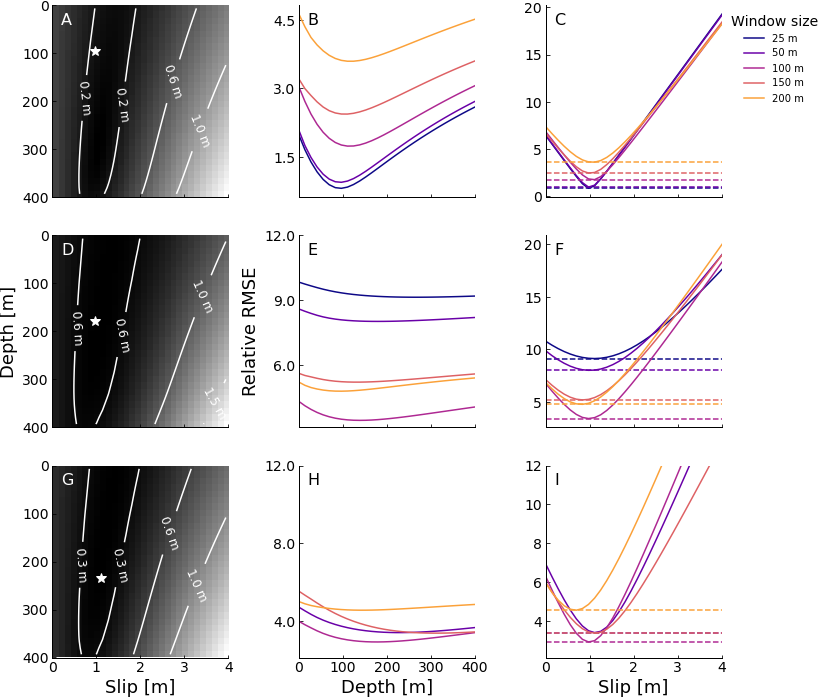

In [125]:
windows = [25, 50, 100, 150, 200]
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

cmap = plt.cm.plasma
colors = [cmap(x) for x in np.linspace(0, 200, num=len(windows), dtype=int)]

for w, color in zip(windows, colors):
    depths, slips, r1 = plot_rmse_2param_dipslip_sameday(dx=w, num=30, max_slip=4, max_depth=400, ax=axes[0, :], color=color, normalize=True)
    _, _, r2 = plot_rmse_2param_dipslip(dx=w, num=30, max_slip=4, max_depth=400, ax=axes[1, :], color=color, normalize=True)
    _, _, r3 = plot_rmse_2param_dipslip_filt(dx=w, num=30, max_slip=4, max_depth=400, ax=axes[2, :], color=color, normalize=True)
    rmses_ds_base.append(r1)
    rmses_ds.append(r2)
    rmses_dsf.append(r3)
    
axes[0, 2].legend(title='Window size', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

axes[0, 0].text(0.05, 0.9, 'A', transform=axes[0, 0].transAxes, fontsize=16, color='w')
axes[0, 1].text(0.05, 0.9, 'B', transform=axes[0, 1].transAxes, fontsize=16)
axes[0, 2].text(0.05, 0.9, 'C', transform=axes[0, 2].transAxes, fontsize=16)

axes[1, 0].text(0.05, 0.9, 'D', transform=axes[1, 0].transAxes, fontsize=16, color='w')
axes[1, 1].text(0.05, 0.9, 'E', transform=axes[1, 1].transAxes, fontsize=16)
axes[1, 2].text(0.05, 0.9, 'F', transform=axes[1, 2].transAxes, fontsize=16)

axes[2, 0].text(0.05, 0.9, 'G', transform=axes[2, 0].transAxes, fontsize=16, color='w')
axes[2, 1].text(0.05, 0.9, 'H', transform=axes[2, 1].transAxes, fontsize=16)
axes[2, 2].text(0.05, 0.9, 'I', transform=axes[2, 2].transAxes, fontsize=16)

axes[1, 0].set_ylabel('Depth [m]')
axes[2, 0].set_xlabel('Slip [m]')
axes[2, 1].set_xlabel('Depth [m]')
axes[2, 2].set_xlabel('Slip [m]')

axes[1, 1].set_ylabel('Relative RMSE')

ymin, _ = axes[1, 1].set_ylim()
axes[1, 1].set_ylim([ymin, 12])
axes[2, 1].set_ylim([ymin - 1, 12])
axes[2, 2].set_ylim([ymin - 1, 12])

for ax in axes[:, 1].ravel():
    ax.set_xlim([0, 400])
    ax.set_xticks([0, 100, 200, 300, 400])

for ax in axes[:, 2].ravel():
    ax.set_xlim([0, 4])
    ax.set_xticks([0, 1, 2, 3, 4])
    
for ax in axes[:, 0].ravel():
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_yticks([0, 100, 200, 300, 400])
    
for ax in axes[:, 1:2].ravel():
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    
for ax in axes[0:2, :].ravel():
    ax.set_xticklabels([])
    
plt.subplots_adjust(wspace=0.4)

plt.savefig(f'/media/rmsare/data/fig/hsl_icp/Figure_RelRMSE_SFM_DS.png', dpi=300, bbox_inches='tight')

Text(0.05, 0.9, 'C')

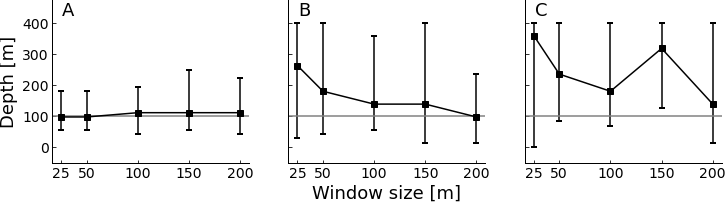

In [140]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True)
m1, u1, l1 = get_rmse_bounds(rmses_ds_base, depths)
ax[0].errorbar(windows, m1, yerr=[l1, u1], marker='s', color='k', ls='-', capsize=3, capthick=2, label='SFM (Same day)')
m2, u2, l2 = get_rmse_bounds(rmses_ds, depths)
ax[1].errorbar(windows, m2, yerr=[l2, u2], marker='s', color='k', ls='-', capsize=3, capthick=2, label='SFM (All points)')
m3, u3, l3 = get_rmse_bounds(rmses_dsf, depths)
ax[2].errorbar(windows, m3, yerr=[l3, u3], marker='s', color='k', ls='-', capsize=3, capthick=2, label='SFM (Ground only)')

for axis in ax:
    xlim = axis.set_xlim()
    axis.hlines([100], xlim[0], xlim[1], linestyles='-', colors='gray')

ax[0].set_xticks(windows)
ax[0].set_ylim([-50, 475])
ax[0].set_yticks([0, 100, 200, 300, 400])

ax[1].set_xlabel('Window size [m]')
ax[0].set_ylabel('Depth [m]')
ax[0].text(0.05, 0.9, 'A', transform=ax[0].transAxes, fontsize=18)
ax[1].text(0.05, 0.9, 'B', transform=ax[1].transAxes, fontsize=18)
ax[2].text(0.05, 0.9, 'C', transform=ax[2].transAxes, fontsize=18)

Text(0.05, 0.9, 'C')

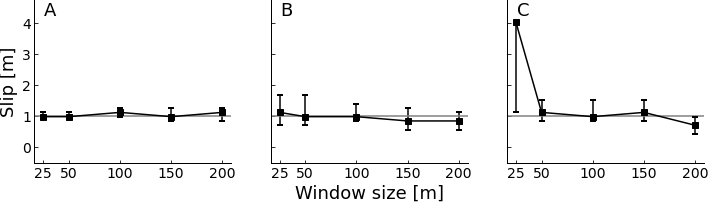

In [142]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True)

m1, u1, l1 = get_rmse_bounds(rmses_ds_base, slips, dim=1)
ax[0].errorbar(windows, m1, yerr=[l1, u1], marker='s', color='k', ls='-', capsize=3, capthick=2)
m2, u2, l2 = get_rmse_bounds(rmses_ds, slips, dim=1)
ax[1].errorbar(windows, m2, yerr=[l2, u2], marker='s', color='k', ls='-', capsize=3, capthick=2)
m3, u3, l3 = get_rmse_bounds(rmses_dsf, slips, dim=1)
ax[2].errorbar(windows, m3, yerr=[l3, u3], marker='s', color='k', ls='-', capsize=3, capthick=2)

for axis in ax:
    xlim = axis.set_xlim()
    axis.hlines([1], xlim[0], xlim[1], linestyles='-', colors='gray')

ax[0].set_xticks(windows)
ax[0].set_ylim([-0.5, 4.75])
ax[0].set_yticks([0, 1, 2, 3, 4])

ax[1].set_xlabel('Window size [m]')
ax[0].set_ylabel('Slip [m]')
ax[0].text(0.05, 0.9, 'A', transform=ax[0].transAxes, fontsize=18)
ax[1].text(0.05, 0.9, 'B', transform=ax[1].transAxes, fontsize=18)
ax[2].text(0.05, 0.9, 'C', transform=ax[2].transAxes, fontsize=18)

IndexError: index 10 is out of bounds for axis 0 with size 10

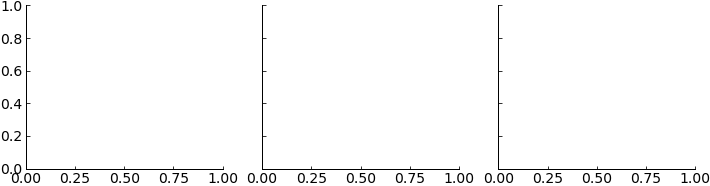

In [157]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True)

m1, u1, l1 = get_rmse_bounds(rmses_ds_base, slips, dim=2)
ax[0].errorbar(windows, m1, yerr=[l1, u1], marker='s', color='k', ls='-', capsize=3, capthick=2)
m2, u2, l2 = get_rmse_bounds(rmses_ds, slips, dim=2)
ax[1].errorbar(windows, m2, yerr=[l2, u2], marker='s', color='k', ls='-', capsize=3, capthick=2)
m3, u3, l3 = get_rmse_bounds(rmses_dsf, slips, dim=2)
ax[2].errorbar(windows, m3, yerr=[l3, u3], marker='s', color='k', ls='-', capsize=3, capthick=2)

for axis in ax:
    xlim = axis.set_xlim()
    axis.hlines([0], xlim[0], xlim[1], linestyles='-', colors='gray')

ax[0].set_xticks(windows)
ax[0].set_ylim([-0.5, 4.75])
ax[0].set_yticks([0, 1, 2, 3, 4])

ax[1].set_xlabel('Window size [m]')
ax[0].set_ylabel('Slip [m]')
ax[0].text(0.05, 0.9, 'A', transform=ax[0].transAxes, fontsize=18)
ax[1].text(0.05, 0.9, 'B', transform=ax[1].transAxes, fontsize=18)
ax[2].text(0.05, 0.9, 'C', transform=ax[2].transAxes, fontsize=18)

In [128]:
rmses_ss_base = []
rmses_ss = []
rmses_ssf = []

Min. RMSE: dx = 12.5 m depth = 96.6 m, dip slip = 0.0 m, strike slip = 0.8 m, RMSE = 0.16 m
Min. RMSE: dx = 12.5 m depth = 179.3 m, dip slip = 0.0 m, strike slip = 1.0 m, RMSE = 0.57 m
Min. RMSE: dx = 12.5 m depth = 0.0 m, dip slip = 4.0 m, strike slip = 4.0 m, RMSE = 683.75 m
Min. RMSE: dx = 25.0 m depth = 55.2 m, dip slip = 0.0 m, strike slip = 0.7 m, RMSE = 0.26 m
Min. RMSE: dx = 25.0 m depth = 193.1 m, dip slip = 0.0 m, strike slip = 1.1 m, RMSE = 0.39 m
Min. RMSE: dx = 25.0 m depth = 248.3 m, dip slip = 0.0 m, strike slip = 1.1 m, RMSE = 0.84 m
Min. RMSE: dx = 50.0 m depth = 55.2 m, dip slip = 0.0 m, strike slip = 0.7 m, RMSE = 0.41 m
Min. RMSE: dx = 50.0 m depth = 41.4 m, dip slip = 0.0 m, strike slip = 0.6 m, RMSE = 0.76 m
Min. RMSE: dx = 50.0 m depth = 13.8 m, dip slip = 0.0 m, strike slip = 0.4 m, RMSE = 0.75 m
Min. RMSE: dx = 75.0 m depth = 96.6 m, dip slip = 0.0 m, strike slip = 0.6 m, RMSE = 0.69 m
Min. RMSE: dx = 75.0 m depth = 0.0 m, dip slip = 0.0 m, strike slip = 0.0 m,

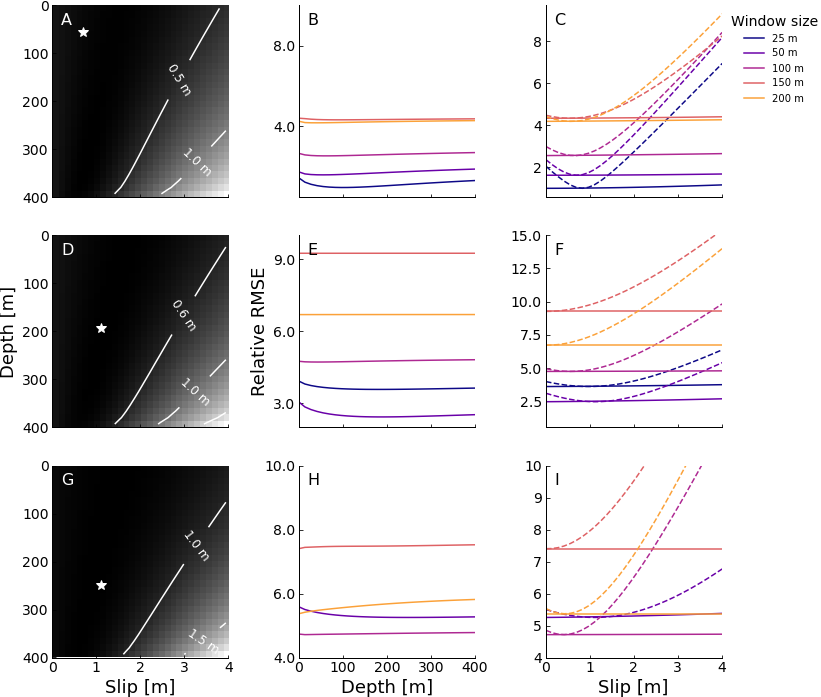

In [129]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

windows = [25, 50, 100, 150, 200]
cmap = plt.cm.plasma
colors = [cmap(x) for x in np.linspace(0, 200, num=len(windows), dtype=int)]

for w, color in zip(windows, colors):
    depths, slips, r1 = plot_rmse_2param_strikeslip_sameday(dx=w, num=30, max_slip=4, max_depth=400, ax=axes[0, :], color=color, normalize=True)
    _, _, r2 = plot_rmse_2param_strikeslip(dx=w, num=30, max_slip=4, max_depth=400, ax=axes[1, :], color=color, normalize=True)
    _, _, r3 = plot_rmse_2param_strikeslip_filt(dx=w, num=30, max_slip=4, max_depth=400, ax=axes[2, :], color=color, normalize=True)
    rmses_ss_base.append(r1)
    rmses_ss.append(r2)
    rmses_ssf.append(r3)
    
axes[0, 2].legend(title='Window size', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

axes[0, 0].text(0.05, 0.9, 'A', transform=axes[0, 0].transAxes, fontsize=16, color='w')
axes[0, 1].text(0.05, 0.9, 'B', transform=axes[0, 1].transAxes, fontsize=16)
axes[0, 2].text(0.05, 0.9, 'C', transform=axes[0, 2].transAxes, fontsize=16)

axes[1, 0].text(0.05, 0.9, 'D', transform=axes[1, 0].transAxes, fontsize=16, color='w')
axes[1, 1].text(0.05, 0.9, 'E', transform=axes[1, 1].transAxes, fontsize=16)
axes[1, 2].text(0.05, 0.9, 'F', transform=axes[1, 2].transAxes, fontsize=16)

axes[2, 0].text(0.05, 0.9, 'G', transform=axes[2, 0].transAxes, fontsize=16, color='w')
axes[2, 1].text(0.05, 0.9, 'H', transform=axes[2, 1].transAxes, fontsize=16)
axes[2, 2].text(0.05, 0.9, 'I', transform=axes[2, 2].transAxes, fontsize=16)

axes[1, 0].set_ylabel('Depth [m]')
axes[2, 0].set_xlabel('Slip [m]')
axes[2, 1].set_xlabel('Depth [m]')
axes[2, 2].set_xlabel('Slip [m]')

axes[1, 1].set_ylabel('Relative RMSE')

axes[0, 1].set_ylim([0.5, 5.5])
axes[0, 1].set_ylim([0.5, 10])

axes[1, 1].set_ylim([2, 10])
axes[1, 2].set_ylim([0.5, 15])

axes[2, 1].set_ylim([4, 10])
axes[2, 2].set_ylim([4, 10])

for ax in axes[:, 1].ravel():
    ax.set_xlim([0, 400])
    ax.set_xticks([0, 100, 200, 300, 400])

for ax in axes[:, 2].ravel():
    ax.set_xlim([0, 4])
    ax.set_xticks([0, 1, 2, 3, 4])
    
for ax in axes[:, 0].ravel():
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_yticks([0, 100, 200, 300, 400])
    
for ax in axes[:, 1:2].ravel():
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    
for ax in axes[0:2, :].ravel():
    ax.set_xticklabels([])
    
plt.subplots_adjust(wspace=0.4)

plt.savefig(f'/media/rmsare/data/fig/hsl_icp/Figure_RelRMSE_SFM_SS.png', dpi=300, bbox_inches='tight')

Text(0.05, 0.9, 'C')

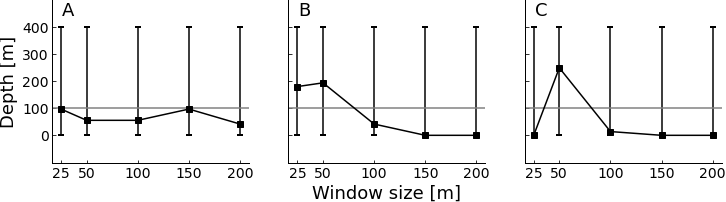

In [136]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True)
m1, u1, l1 = get_rmse_bounds(rmses_ss_base, depths)
ax[0].errorbar(windows, m1, yerr=[l1, u1], marker='s', color='k', ls='-', capsize=3, capthick=2, label='SFM (Same day)')
m2, u2, l2 = get_rmse_bounds(rmses_ss, depths)
ax[1].errorbar(windows, m2, yerr=[l2, u2], marker='s', color='k', ls='-', capsize=3, capthick=2, label='SFM (All points)')
m3, u3, l3 = get_rmse_bounds(rmses_ssf, depths)
ax[2].errorbar(windows, m3, yerr=[l3, u3], marker='s', color='k', ls='-', capsize=3, capthick=2, label='SFM (Ground only)')

for axis in ax:
    xlim = axis.set_xlim()
    axis.hlines([100], xlim[0], xlim[1], linestyles='-', colors='gray')

ax[0].set_xticks(windows)
ax[0].set_ylim([-100, 500])
ax[0].set_yticks([0, 100, 200, 300, 400])
ax[1].set_xlabel('Window size [m]')
ax[0].set_ylabel('Depth [m]')
ax[0].text(0.05, 0.9, 'A', transform=ax[0].transAxes, fontsize=18)
ax[1].text(0.05, 0.9, 'B', transform=ax[1].transAxes, fontsize=18)
ax[2].text(0.05, 0.9, 'C', transform=ax[2].transAxes, fontsize=18)

Text(0.05, 0.9, 'C')

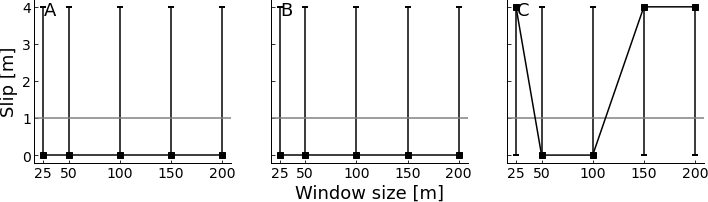

In [137]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True)

m1, u1, l1 = get_rmse_bounds(rmses_ss_base, slips, dim=1)
ax[0].errorbar(windows, m1, yerr=[l1, u1], marker='s', color='k', ls='-', capsize=3, capthick=2)
m2, u2, l2 = get_rmse_bounds(rmses_ss, slips, dim=1)
ax[1].errorbar(windows, m2, yerr=[l2, u2], marker='s', color='k', ls='-', capsize=3, capthick=2)
m3, u3, l3 = get_rmse_bounds(rmses_ssf, slips, dim=1)
ax[2].errorbar(windows, m3, yerr=[l3, u3], marker='s', color='k', ls='-', capsize=3, capthick=2)

for axis in ax:
    xlim = axis.set_xlim()
    axis.hlines([0], xlim[0], xlim[1],  linestyles='-', colors='gray')
    
ax[0].set_xticks(windows)
ax[1].set_xlabel('Window size [m]')
ax[0].set_ylabel('Slip [m]')
ax[0].text(0.05, 0.9, 'A', transform=ax[0].transAxes, fontsize=18)
ax[1].text(0.05, 0.9, 'B', transform=ax[1].transAxes, fontsize=18)
ax[2].text(0.05, 0.9, 'C', transform=ax[2].transAxes, fontsize=18)

Text(0.05, 0.9, 'C')

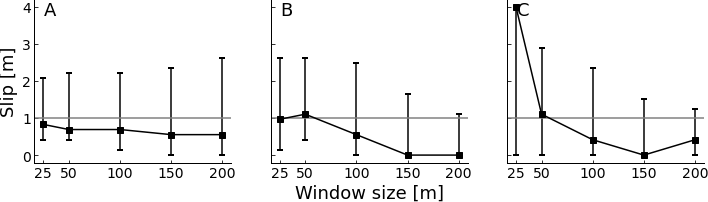

In [138]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True)

m1, u1, l1 = get_rmse_bounds(rmses_ss_base, slips, dim=2)
ax[0].errorbar(windows, m1, yerr=[l1, u1], marker='s', color='k', ls='-', capsize=3, capthick=2)
m2, u2, l2 = get_rmse_bounds(rmses_ss, slips, dim=2)
ax[1].errorbar(windows, m2, yerr=[l2, u2], marker='s', color='k', ls='-', capsize=3, capthick=2)
m3, u3, l3 = get_rmse_bounds(rmses_ssf, slips, dim=2)
ax[2].errorbar(windows, m3, yerr=[l3, u3], marker='s', color='k', ls='-', capsize=3, capthick=2)

for axis in ax:
    xlim = axis.set_xlim()
    axis.hlines([1], xlim[0], xlim[1],  linestyles='-', colors='gray')
    
ax[0].set_xticks(windows)
ax[1].set_xlabel('Window size [m]')
ax[0].set_ylabel('Slip [m]')
ax[0].text(0.05, 0.9, 'A', transform=ax[0].transAxes, fontsize=18)
ax[1].text(0.05, 0.9, 'B', transform=ax[1].transAxes, fontsize=18)
ax[2].text(0.05, 0.9, 'C', transform=ax[2].transAxes, fontsize=18)

In [152]:
rmses_sst_base = []
rmses_sst = []
rmses_sstf = []

Min. RMSE: dx = 12.5 m depth = 110.4 m, dip slip = 0.0 m, strike slip = 1.7 m, RMSE = 0.30 m
Min. RMSE: dx = 12.5 m depth = 234.5 m, dip slip = 0.0 m, strike slip = 2.1 m, RMSE = 0.46 m
Min. RMSE: dx = 12.5 m depth = 400.0 m, dip slip = 0.0 m, strike slip = 0.0 m, RMSE = 252.11 m
Min. RMSE: dx = 25.0 m depth = 110.4 m, dip slip = 0.0 m, strike slip = 1.7 m, RMSE = 0.21 m
Min. RMSE: dx = 25.0 m depth = 151.7 m, dip slip = 0.0 m, strike slip = 1.8 m, RMSE = 0.55 m
Min. RMSE: dx = 25.0 m depth = 206.9 m, dip slip = 0.0 m, strike slip = 1.8 m, RMSE = 0.88 m
Min. RMSE: dx = 50.0 m depth = 82.8 m, dip slip = 0.0 m, strike slip = 1.4 m, RMSE = 0.40 m
Min. RMSE: dx = 50.0 m depth = 96.6 m, dip slip = 0.0 m, strike slip = 1.4 m, RMSE = 0.65 m
Min. RMSE: dx = 50.0 m depth = 55.2 m, dip slip = 0.0 m, strike slip = 1.0 m, RMSE = 0.80 m
Min. RMSE: dx = 75.0 m depth = 96.6 m, dip slip = 0.3 m, strike slip = 1.3 m, RMSE = 0.67 m
Min. RMSE: dx = 75.0 m depth = 55.2 m, dip slip = 0.8 m, strike slip = 0

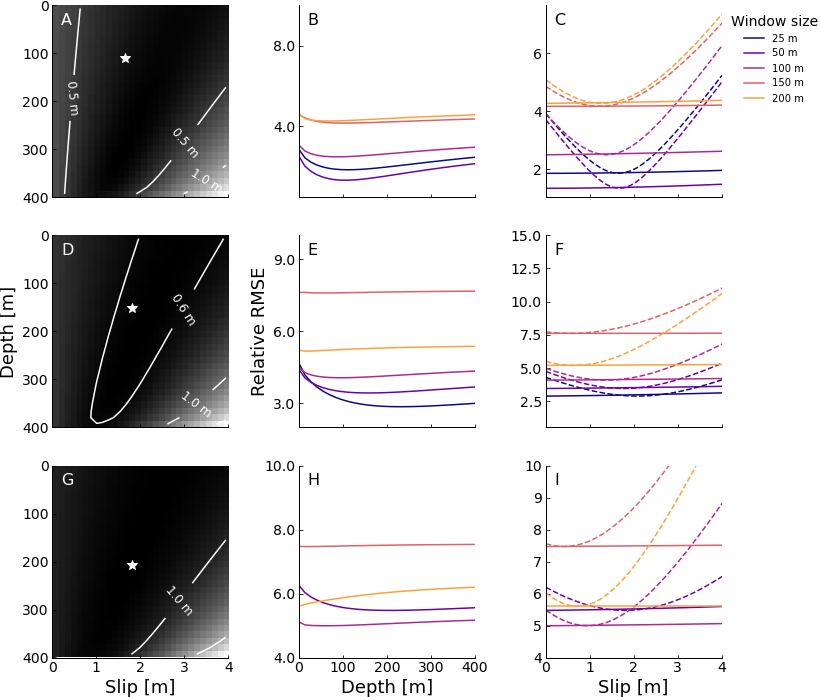

In [171]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

windows = [25, 50, 100, 150, 200]
cmap = plt.cm.plasma
colors = [cmap(x) for x in np.linspace(0, 200, num=len(windows), dtype=int)]

for w, color in zip(windows, colors):
    depths, slips, r1 = plot_rmse_2param_strikeslip_sameday_thin_2(dx=w, num=30, max_slip=4, max_depth=400, ax=axes[0, :], color=color, normalize=True)
    _, _, r2 = plot_rmse_2param_strikeslip_thin_2(dx=w, num=30, max_slip=4, max_depth=400, ax=axes[1, :], color=color, normalize=True)
    _, _, r3 = plot_rmse_2param_strikeslip_filt_thin_2(dx=w, num=30, max_slip=4, max_depth=400, ax=axes[2, :], color=color, normalize=True)
    rmses_sst_base.append(r1)
    rmses_sst.append(r2)
    rmses_sstf.append(r3)
    
axes[0, 2].legend(title='Window size', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

axes[0, 0].text(0.05, 0.9, 'A', transform=axes[0, 0].transAxes, fontsize=16, color='w')
axes[0, 1].text(0.05, 0.9, 'B', transform=axes[0, 1].transAxes, fontsize=16)
axes[0, 2].text(0.05, 0.9, 'C', transform=axes[0, 2].transAxes, fontsize=16)

axes[1, 0].text(0.05, 0.9, 'D', transform=axes[1, 0].transAxes, fontsize=16, color='w')
axes[1, 1].text(0.05, 0.9, 'E', transform=axes[1, 1].transAxes, fontsize=16)
axes[1, 2].text(0.05, 0.9, 'F', transform=axes[1, 2].transAxes, fontsize=16)

axes[2, 0].text(0.05, 0.9, 'G', transform=axes[2, 0].transAxes, fontsize=16, color='w')
axes[2, 1].text(0.05, 0.9, 'H', transform=axes[2, 1].transAxes, fontsize=16)
axes[2, 2].text(0.05, 0.9, 'I', transform=axes[2, 2].transAxes, fontsize=16)

axes[1, 0].set_ylabel('Depth [m]')
axes[2, 0].set_xlabel('Slip [m]')
axes[2, 1].set_xlabel('Depth [m]')
axes[2, 2].set_xlabel('Slip [m]')

axes[1, 1].set_ylabel('Relative RMSE')

axes[0, 1].set_ylim([0.5, 5.5])
axes[0, 1].set_ylim([0.5, 10])

axes[1, 1].set_ylim([2, 10])
axes[1, 2].set_ylim([0.5, 15])

axes[2, 1].set_ylim([4, 10])
axes[2, 2].set_ylim([4, 10])

for ax in axes[:, 1].ravel():
    ax.set_xlim([0, 400])
    ax.set_xticks([0, 100, 200, 300, 400])

for ax in axes[:, 2].ravel():
    ax.set_xlim([0, 4])
    ax.set_xticks([0, 1, 2, 3, 4])
    
for ax in axes[:, 0].ravel():
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_yticks([0, 100, 200, 300, 400])
    
for ax in axes[:, 1:2].ravel():
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    
for ax in axes[0:2, :].ravel():
    ax.set_xticklabels([])
    
plt.subplots_adjust(wspace=0.4)

plt.savefig(f'/media/rmsare/data/fig/hsl_icp/Figure_RelRMSE_SFM_SS_2m.png', dpi=300, bbox_inches='tight')

ValueError: shape mismatch: objects cannot be broadcast to a single shape

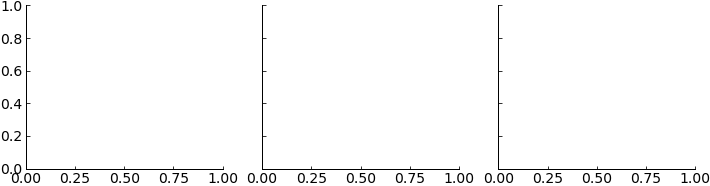

In [172]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True)
m1, u1, l1 = get_rmse_bounds(rmses_sst_base, depths)
ax[0].errorbar(windows, m1, yerr=[l1, u1], marker='s', color='k', ls='-', capsize=3, capthick=2, label='SFM (Same day)')
m2, u2, l2 = get_rmse_bounds(rmses_sst, depths)
ax[1].errorbar(windows, m2, yerr=[l2, u2], marker='s', color='k', ls='-', capsize=3, capthick=2, label='SFM (All points)')
m3, u3, l3 = get_rmse_bounds(rmses_sstf, depths)
ax[2].errorbar(windows, m3, yerr=[l3, u3], marker='s', color='k', ls='-', capsize=3, capthick=2, label='SFM (Ground only)')

for axis in ax:
    xlim = axis.set_xlim()
    axis.hlines([100], xlim[0], xlim[1], linestyles='-', colors='gray')

ax[0].set_xticks(windows)
ax[0].set_ylim([-100, 500])
ax[0].set_yticks([0, 100, 200, 300, 400])
ax[1].set_xlabel('Window size [m]')
ax[0].set_ylabel('Depth [m]')
ax[0].text(0.05, 0.9, 'A', transform=ax[0].transAxes, fontsize=18)
ax[1].text(0.05, 0.9, 'B', transform=ax[1].transAxes, fontsize=18)
ax[2].text(0.05, 0.9, 'C', transform=ax[2].transAxes, fontsize=18)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True)

m1, u1, l1 = get_rmse_bounds(rmses_sst_base, slips, dim=1)
ax[0].errorbar(windows, m1, yerr=[l1, u1], marker='s', color='k', ls='-', capsize=3, capthick=2)
m2, u2, l2 = get_rmse_bounds(rmses_sst, slips, dim=1)
ax[1].errorbar(windows, m2, yerr=[l2, u2], marker='s', color='k', ls='-', capsize=3, capthick=2)
m3, u3, l3 = get_rmse_bounds(rmses_sstf, slips, dim=1)
ax[2].errorbar(windows, m3, yerr=[l3, u3], marker='s', color='k', ls='-', capsize=3, capthick=2)

for axis in ax:
    xlim = axis.set_xlim()
    axis.hlines([0], xlim[0], xlim[1],  linestyles='-', colors='gray')
    
ax[0].set_xticks(windows)
ax[1].set_xlabel('Window size [m]')
ax[0].set_ylabel('Slip [m]')
ax[0].text(0.05, 0.9, 'A', transform=ax[0].transAxes, fontsize=18)
ax[1].text(0.05, 0.9, 'B', transform=ax[1].transAxes, fontsize=18)
ax[2].text(0.05, 0.9, 'C', transform=ax[2].transAxes, fontsize=18)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True)

m1, u1, l1 = get_rmse_bounds(rmses_sst_base, slips, dim=2)
ax[0].errorbar(windows, m1, yerr=[l1, u1], marker='s', color='k', ls='-', capsize=3, capthick=2)
m2, u2, l2 = get_rmse_bounds(rmses_sst, slips, dim=2)
ax[1].errorbar(windows, m2, yerr=[l2, u2], marker='s', color='k', ls='-', capsize=3, capthick=2)
m3, u3, l3 = get_rmse_bounds(rmses_sstf, slips, dim=2)
ax[2].errorbar(windows, m3, yerr=[l3, u3], marker='s', color='k', ls='-', capsize=3, capthick=2)

for axis in ax:
    xlim = axis.set_xlim()
    axis.hlines([2], xlim[0], xlim[1],  linestyles='-', colors='gray')
    
ax[0].set_xticks(windows)
ax[1].set_xlabel('Window size [m]')
ax[0].set_ylabel('Slip [m]')
ax[0].text(0.05, 0.9, 'A', transform=ax[0].transAxes, fontsize=18)
ax[1].text(0.05, 0.9, 'B', transform=ax[1].transAxes, fontsize=18)
ax[2].text(0.05, 0.9, 'C', transform=ax[2].transAxes, fontsize=18)

Min. RMSE: dx = 12.5 m depth = 69.0 m, dip slip = 0.8 m, strike slip = 0.0 m, RMSE = 2.82 m
Min. RMSE: dx = 12.5 m depth = 96.6 m, dip slip = 1.0 m, strike slip = 0.0 m, RMSE = 0.03 m
Min. RMSE: dx = 25.0 m depth = 96.6 m, dip slip = 1.0 m, strike slip = 0.0 m, RMSE = 0.04 m
Min. RMSE: dx = 25.0 m depth = 96.6 m, dip slip = 1.0 m, strike slip = 0.0 m, RMSE = 0.02 m
Min. RMSE: dx = 50.0 m depth = 96.6 m, dip slip = 1.0 m, strike slip = 0.0 m, RMSE = 0.06 m
Min. RMSE: dx = 50.0 m depth = 110.4 m, dip slip = 1.0 m, strike slip = 0.0 m, RMSE = 0.04 m
Min. RMSE: dx = 75.0 m depth = 124.1 m, dip slip = 1.0 m, strike slip = 0.0 m, RMSE = 0.08 m
Min. RMSE: dx = 75.0 m depth = 179.3 m, dip slip = 1.1 m, strike slip = 0.0 m, RMSE = 0.04 m
Min. RMSE: dx = 100.0 m depth = 137.9 m, dip slip = 1.0 m, strike slip = 0.0 m, RMSE = 0.10 m
Min. RMSE: dx = 100.0 m depth = 220.7 m, dip slip = 1.1 m, strike slip = 0.0 m, RMSE = 0.05 m


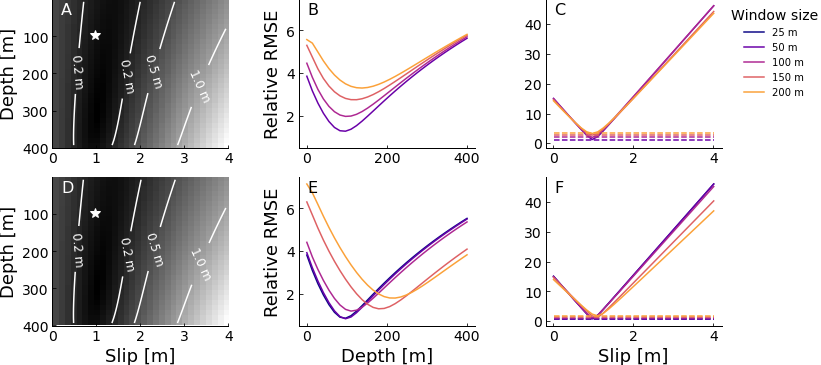

In [57]:
windows = [25, 50, 100, 150, 200]
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

cmap = plt.cm.plasma
colors = [cmap(x) for x in np.linspace(0, 200, num=len(windows), dtype=int)]

for w, color in zip(windows, colors):
    _ = plot_rmse_2param_dipslip_lidar(dx=w, num=30, max_slip=4, max_depth=400, ax=axes[0, :], color=color, normalize=True)
    _ = plot_rmse_2param_dipslip_lidar_filt(dx=w, num=30, max_slip=4, max_depth=400, ax=axes[1, :], color=color, normalize=True)
    
axes[0, 2].legend(title='Window size', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

axes[0, 0].set_ylabel('Depth [m]')
axes[1, 0].set_ylabel('Depth [m]')
axes[1, 0].set_xlabel('Slip [m]')
axes[1, 1].set_xlabel('Depth [m]')
axes[1, 2].set_xlabel('Slip [m]')

axes[0, 1].set_ylabel('Relative RMSE')
axes[1, 1].set_ylabel('Relative RMSE')

axes[0, 1].set_ylim(axes[1, 1].set_ylim())
axes[0, 2].set_ylim(axes[1, 2].set_ylim())

plt.subplots_adjust(wspace=0.4)

axes[0, 0].text(0.05, 0.9, 'A', transform=axes[0, 0].transAxes, fontsize=16, color='w')
axes[0, 1].text(0.05, 0.9, 'B', transform=axes[0, 1].transAxes, fontsize=16)
axes[0, 2].text(0.05, 0.9, 'C', transform=axes[0, 2].transAxes, fontsize=16)

axes[1, 0].text(0.05, 0.9, 'D', transform=axes[1, 0].transAxes, fontsize=16, color='w')
axes[1, 1].text(0.05, 0.9, 'E', transform=axes[1, 1].transAxes, fontsize=16)
axes[1, 2].text(0.05, 0.9, 'F', transform=axes[1, 2].transAxes, fontsize=16)

plt.savefig(f'/media/rmsare/data/fig/hsl_icp/Figure_RelRMSE_LidarDS.png', dpi=300, bbox_inches='tight')

Min. RMSE: dx = 12.5 m depth = 13.8 m, dip slip = 0.0 m, strike slip = 0.3 m, RMSE = 9.42 m
Min. RMSE: dx = 12.5 m depth = 124.1 m, dip slip = 0.0 m, strike slip = 1.0 m, RMSE = 0.09 m
Min. RMSE: dx = 25.0 m depth = 110.4 m, dip slip = 0.0 m, strike slip = 0.8 m, RMSE = 0.14 m
Min. RMSE: dx = 25.0 m depth = 124.1 m, dip slip = 0.0 m, strike slip = 1.0 m, RMSE = 0.09 m
Min. RMSE: dx = 50.0 m depth = 179.3 m, dip slip = 0.0 m, strike slip = 1.0 m, RMSE = 0.21 m
Min. RMSE: dx = 50.0 m depth = 124.1 m, dip slip = 0.1 m, strike slip = 1.0 m, RMSE = 0.13 m
Min. RMSE: dx = 75.0 m depth = 275.9 m, dip slip = 0.0 m, strike slip = 1.1 m, RMSE = 0.27 m
Min. RMSE: dx = 75.0 m depth = 179.3 m, dip slip = 0.0 m, strike slip = 1.1 m, RMSE = 0.14 m
Min. RMSE: dx = 100.0 m depth = 248.3 m, dip slip = 0.0 m, strike slip = 0.8 m, RMSE = 0.40 m
Min. RMSE: dx = 100.0 m depth = 179.3 m, dip slip = 0.0 m, strike slip = 1.1 m, RMSE = 0.18 m


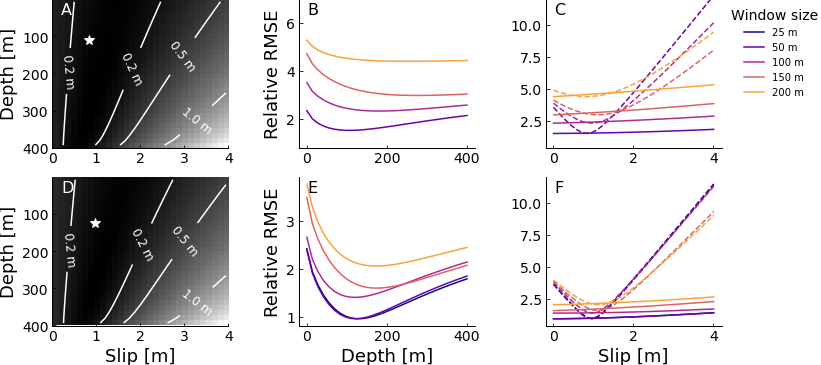

In [61]:
windows = [25, 50, 100, 150, 200]
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

cmap = plt.cm.plasma
colors = [cmap(x) for x in np.linspace(0, 200, num=len(windows), dtype=int)]

for w, color in zip(windows, colors):
    _ = plot_rmse_2param_strikeslip_lidar(dx=w, num=30, max_slip=4, max_depth=400, ax=axes[0, :], color=color, normalize=True)
    _ = plot_rmse_2param_strikeslip_lidar_filt(dx=w, num=30, max_slip=4, max_depth=400, ax=axes[1, :], color=color, normalize=True)
    
axes[0, 2].legend(title='Window size', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

axes[0, 0].set_ylabel('Depth [m]')
axes[1, 0].set_ylabel('Depth [m]')
axes[1, 0].set_xlabel('Slip [m]')
axes[1, 1].set_xlabel('Depth [m]')
axes[1, 2].set_xlabel('Slip [m]')

axes[0, 1].set_ylabel('Relative RMSE')
axes[1, 1].set_ylabel('Relative RMSE')

ymin, _ = axes[1, 1].set_ylim()
axes[0, 1].set_ylim([ymin, 7])
axes[0, 2].set_ylim(axes[1, 2].set_ylim())

plt.subplots_adjust(wspace=0.4)

axes[0, 0].text(0.05, 0.9, 'A', transform=axes[0, 0].transAxes, fontsize=16, color='w')
axes[0, 1].text(0.05, 0.9, 'B', transform=axes[0, 1].transAxes, fontsize=16)
axes[0, 2].text(0.05, 0.9, 'C', transform=axes[0, 2].transAxes, fontsize=16)

axes[1, 0].text(0.05, 0.9, 'D', transform=axes[1, 0].transAxes, fontsize=16, color='w')
axes[1, 1].text(0.05, 0.9, 'E', transform=axes[1, 1].transAxes, fontsize=16)
axes[1, 2].text(0.05, 0.9, 'F', transform=axes[1, 2].transAxes, fontsize=16)

plt.savefig(f'/media/rmsare/data/fig/hsl_icp/Figure_RelRMSE_LidarSS.png', dpi=300, bbox_inches='tight')